# Lesson 6: Connecting Text and Images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jonathandinu/programming-generative-ai/blob/main/notebooks/06-connecting-text-images.ipynb) [![GitHub Repo stars](https://img.shields.io/github/stars/jonathandinu/programming-generative-ai?style=social)](https://github.com/jonathandinu/programming-generative-ai)

> Colab for interactive execution in your browser (no setup) and repository for notebook index and additional resources (slides, etc.)

In [1]:
# install dependencies for cloud notebook environments, i.e. Google Colab
%pip install -U diffusers["torch"] torch torchvision transformers matplotlib scikit-image datasets

  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.20.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)


In [2]:
import torch
from pprint import pprint

# default device boilerplate
device = (
    "cuda" # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps" # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 6.4 Embedding Text and Images with CLIP

Conceptual Captions dataset: https://ai.google.com/research/ConceptualCaptions/

In [3]:
from transformers import CLIPProcessor, CLIPModel, CLIPTextModelWithProjection

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
inputs = processor.tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

pooled_output = model.text_model(**inputs.to(device)).pooler_output
text_embeds = model.text_projection(pooled_output)

In [6]:
text_embeds.shape

torch.Size([2, 512])

In [7]:
text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to(device)

outputs = text_model(**inputs)
text_embeds2 = outputs.text_embeds

In [8]:
torch.all(text_embeds == text_embeds2)

tensor(True, device='cuda:0')

In [9]:
from datasets import load_dataset

In [10]:
cc = load_dataset("google-research-datasets/conceptual_captions", split="validation")

README.md:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

In [11]:
cc[0]

{'image_url': 'https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg',
 'caption': 'author : a life in photography -- in pictures'}

In [12]:
cats = cc.filter(lambda x: 'cat' in x['caption'].split(' '))
other = cc.filter(lambda x: 'cat' not in x['caption'].split(' '))

Filter:   0%|          | 0/15840 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15840 [00:00<?, ? examples/s]

In [13]:
example =  {
  'image_url': 'https://i.pinimg.com/736x/05/c1/e3/05c1e34d8009c509839e65b1b108bd75--the-netherlands-get-back.jpg',
  'caption': 'our neighbors have such a cute cat !'
}

In [14]:
from PIL import Image
import requests

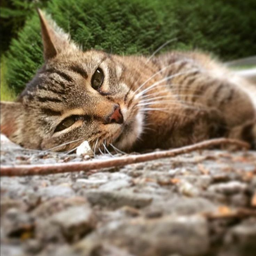

In [15]:
image = Image.open(requests.get(example['image_url'], stream=True).raw).resize((256, 256))
image

In [16]:
inputs = processor(images=image, return_tensors="pt").to(device)

outputs = model.vision_model(**inputs)
pooled_output = outputs.pooler_output
image_embeds = model.visual_projection(pooled_output)

In [17]:
image_embeds.shape

torch.Size([1, 512])

In [18]:
queries = ["a photo of a cat", "a photo of a hotdog", "a photo of a tiger", "lorem ipsum"]
multi_inputs = processor(text=queries, images=image, return_tensors="pt", padding=True)
outputs = model(**multi_inputs.to(device))

# image-text similarity
logits_per_image = outputs.logits_per_image

## 6.5 Zero-Shot Image Classification with CLIP

In [19]:
logits_per_image

tensor([[29.2001, 19.0298, 26.8121, 20.6269]], device='cuda:0',
       grad_fn=<TBackward0>)

In [20]:
# zero-shot classification
probs = logits_per_image.softmax(dim=1)
probs

tensor([[9.1572e-01, 3.5063e-05, 8.4073e-02, 1.7315e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [21]:
from tqdm import tqdm

other_images = []
captions = []
seed = 666
subset = other.shuffle(seed=seed)[:100]

for i, url in tqdm(enumerate(subset['image_url'])):
  try:
    res = requests.get(url, stream=True)
    if res.ok:
      other_images.append(Image.open(res.raw))
      captions.append(subset['caption'][i])
  except:
    pass

100it [00:49,  2.02it/s]


## 6.6 Semantic Image Search with CLIP

In [22]:
cat_images = []
subset = cats.shuffle(seed=seed)[:5]

for i, url in tqdm(enumerate(subset['image_url'])):
  try:
    res = requests.get(url, stream=True)
    if res.ok:
      cat_images.append(Image.open(res.raw))
      captions.append(subset['caption'][i])
  except:
    pass

5it [00:02,  1.97it/s]


In [23]:
f"We have {len(cat_images)} cats and {len(other_images)} not-cat photos"

'We have 5 cats and 67 not-cat photos'

In [24]:
all_images = other_images + cat_images

In [25]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

query = ["a cat on a couch"]
multi_inputs = processor(text=query, images=all_images, return_tensors="pt", padding=True)
outputs = model(**multi_inputs.to(device))

# image-text similarity
logits_per_image = outputs.logits_per_image

In [26]:
logits_per_image.shape

torch.Size([72, 1])

In [27]:
values, indices = logits_per_image.squeeze().topk(5)

In [28]:
indices

tensor([68, 14, 67, 69, 40], device='cuda:0')

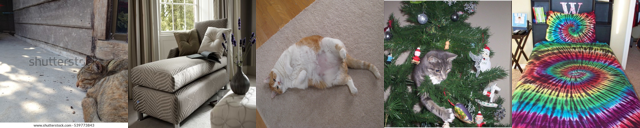

In [29]:
from diffusers import utils

utils.make_image_grid([all_images[i].resize((128, 128)) for i in indices], rows=1, cols=5)

In [30]:
[ captions[i] for i in indices ]

['a cat sleeping in front of the door',
 'couches in a modern house',
 'fat cat lays on the carpet , fluffy tummy exposed',
 'person the cat literally up a christmas tree .',
 'person will have a set ! :)']

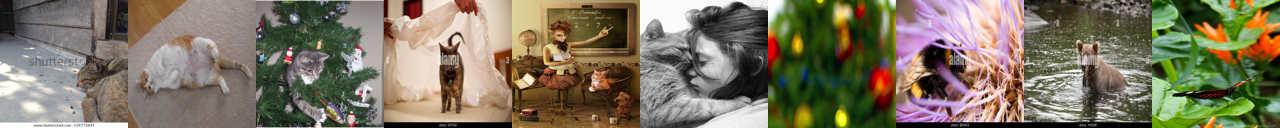

In [31]:
def semantic_search(query, k=3):
  multi_inputs = processor(text=query, images=all_images, return_tensors="pt", padding=True)
  outputs = model(**multi_inputs.to(device))

  # image-text similarity
  logits_per_image = outputs.logits_per_image

  values, indices = logits_per_image.squeeze().topk(k)
  return indices, utils.make_image_grid([all_images[i].resize((128, 128)) for i in indices], rows=1, cols=k)

semantic_search(["a cat"], 10)[1]

In [32]:
indices, grid = semantic_search(["a person holding a kitchen utensil"], 10)

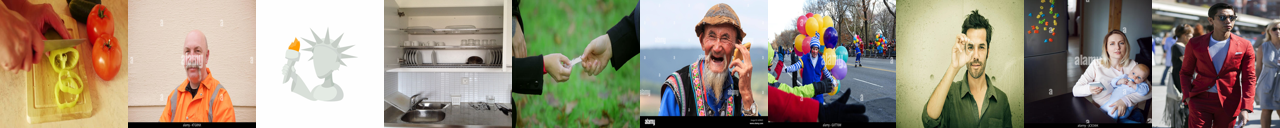

In [33]:
grid

In [34]:
[ captions[i] for i in indices ]

['a woman with a knife cuts pepper on a cutting board in the kitchen',
 'person in a high - visibility jacket - head and shoulders',
 'head in cartoon style on a white background',
 'another intelligent design idea : cupboards above sink for dishes have grill instead of wood so water drains away from just - cleaned dishes .',
 'in this video , we can see that a man and a woman are holding a white feather in their hands .',
 'an old man dressed with the traditional attire using a telephone',
 'a rollerblading clown shakes hands with waiting spectators before event begins',
 'man looking through a round lens',
 'young mother with baby sits and uses the phone .',
 'dress up your favorite suit and casual shirt with a classic white pocket square']

## 6.11 Stable Diffusion Deconstructed

* Original latent diffusion model (LDM) paper: https://arxiv.org/abs/2112.10752
* Original LDM Github repo: https://github.com/CompVis/latent-diffusion
* Stable Diffusion repo: https://github.com/CompVis/stable-diffusion

In [35]:
from diffusers import DiffusionPipeline
from diffusers import utils
from IPython.display import display, clear_output

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
pipeline("an astronaut riding a seahorse")

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7E06963B0280>], nsfw_content_detected=[False])

  0%|          | 0/50 [00:00<?, ?it/s]

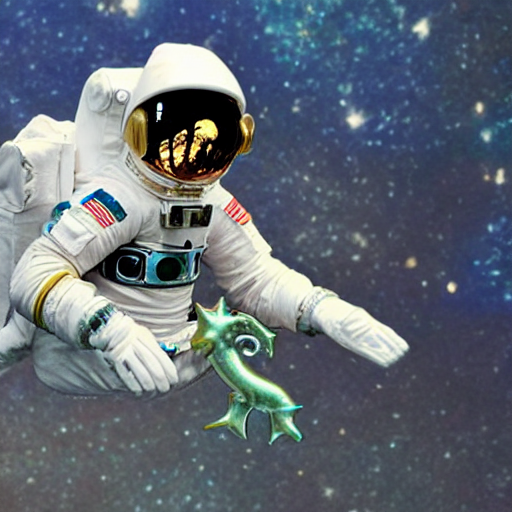

In [37]:
pipeline("an astronaut riding a seahorse").images[0]

In [38]:
pipeline.config

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')),
            ('text_encoder', ('transformers', 'CLIPTextModel')),
            ('tokenizer', ('transformers', 'CLIPTokenizer')),
            ('unet', ('diffusers', 'UNet2DConditionModel')),
            ('scheduler', ('diffusers', 'PNDMScheduler')),
            ('safety_checker',
             ('stable_diffusion', 'StableDiffusionSafetyChecker')),
            ('feature_extractor', ('transformers', 'CLIPImageProcessor')),
            ('image_encoder', (None, None)),
            ('requires_safety_checker', True),
            ('_name_or_path', 'runwayml/stable-diffusion-v1-5')])

In [39]:
pipeline.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [40]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [41]:
pipeline.text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

## 6.12 Writing our Own Stable Diffusion Pipeline

In [42]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler

model_id = "runwayml/stable-diffusion-v1-5"
generator = torch.Generator(device="cpu").manual_seed(666)

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", torch_dtype=torch.float16
)

vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae",  torch_dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16
)

scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [43]:
vae.to(device)
unet.to(device)
text_encoder.to(device)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [44]:
prompt = ["an astronaut riding a seahorse"]

prompt_tokens = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
).to(device)

with torch.no_grad():
  prompt_embeddings = text_encoder(prompt_tokens.input_ids)[0]

In [45]:
prompt_embeddings.shape

torch.Size([1, 77, 768])

In [46]:
prompt_tokens

{'input_ids': tensor([[49406,   550, 18376,  6765,   320,  5970,  4558, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]], device='cuda:0')}

In [47]:
lwidth = lheight = 64

init_noise = torch.randn(
    (len(prompt), unet.config.in_channels, lheight, lwidth),
    generator=generator,
    dtype=torch.float16
).to(device)

In [48]:
unet.config.in_channels

4

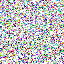

In [49]:
utils.pt_to_pil(init_noise)[0]

In [50]:
scheduler.init_noise_sigma

1.0

In [51]:
from tqdm.auto import tqdm

scheduler.set_timesteps(50)
latents = init_noise * scheduler.init_noise_sigma

for t in tqdm(scheduler.timesteps):
    latents = scheduler.scale_model_input(latents, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_resi = unet(latents, t, encoder_hidden_states=prompt_embeddings).sample

    latents = scheduler.step(noise_resi, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

## 6.13 Decoding Images from the Stable Diffusion Latent Space

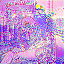

In [52]:
utils.pt_to_pil(latents)[0]

In [53]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

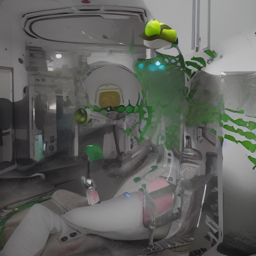

In [54]:
utils.pt_to_pil(image)[0].resize((256, 256))

## 6.14 Improving Generation with Guidance

Classifier-Free Diffusion Guidance paper: https://arxiv.org/abs/2207.12598

In [55]:
max_length = prompt_tokens.input_ids.shape[-1]
uncond_tokens = tokenizer([""] * len(prompt),
                         padding="max_length",
                         max_length=max_length,
                         return_tensors="pt").to(device)

uncond_embeddings = text_encoder(uncond_tokens.input_ids)[0]

In [56]:
uncond_embeddings.shape

torch.Size([1, 77, 768])

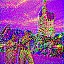

In [57]:
from tqdm.auto import tqdm

scheduler.set_timesteps(50)

guidance_scale = 0.01
text_embeddings = torch.cat([uncond_embeddings, prompt_embeddings])

latents = init_noise * scheduler.init_noise_sigma

for t in tqdm(scheduler.timesteps):
    latent_unet = torch.cat([latents] * 2)
    latent_unet = scheduler.scale_model_input(latent_unet, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_resi = unet(latent_unet, t, encoder_hidden_states=text_embeddings).sample

    # perform classifier free guidance
    noise_resi_uncond, noise_resi_cond = noise_resi.chunk(2)
    noise_resi = noise_resi_uncond + guidance_scale * (noise_resi_cond - noise_resi_uncond)

    latents = scheduler.step(noise_resi, t, latents).prev_sample

    clear_output(wait=True)
    display(utils.pt_to_pil(latents[:, :3, :, :])[0])

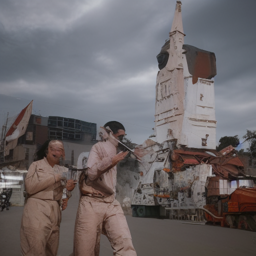

In [58]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

utils.pt_to_pil(image)[0].resize((256, 256))

## 6.15 Playing with Prompts

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

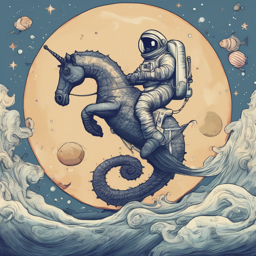

In [59]:
import torch
import numpy as np
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", vae=vae, torch_dtype=torch.float16, variant="fp16")
pipeline.to("cuda")

prompt = "An astronaut riding a seahorse"

image = pipeline(prompt=prompt, num_inference_steps=50).images[0]
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

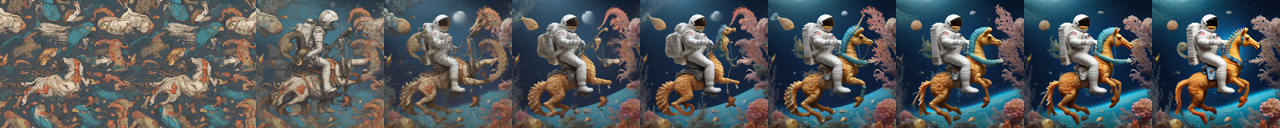

In [60]:
images = [pipeline(prompt=prompt, num_inference_steps=50, guidance_scale=g, generator=torch.manual_seed(1)) for g in np.linspace(0, 10, 10)]
utils.make_image_grid([img.images[0].resize((128, 128)) for img in images], rows=1, cols=10)

  0%|          | 0/30 [00:00<?, ?it/s]

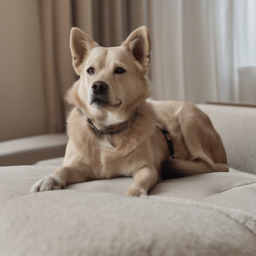

In [61]:
prompt = "A dog sitting on top of a cat"

image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
image.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

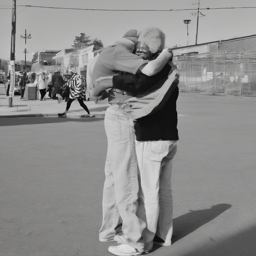

In [62]:
prompt = "A person hugging a stranger"

image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
image.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

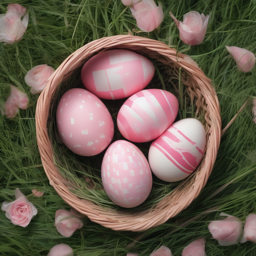

In [63]:
prompt = "three easter eggs painted pink in a basket of green grass"

image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
image.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

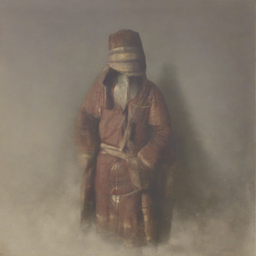

In [64]:
prompt = "A photograph of Jonathan Dinu"

image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
image.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

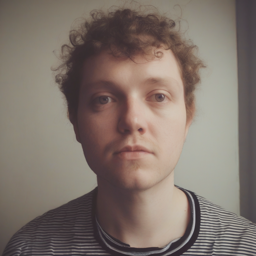

In [65]:
prompt = "A photo of me looking directly into the camera"

image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
image.resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

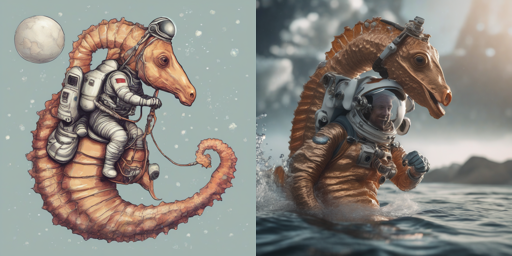

In [66]:
prompt = "An astronaut riding a seahorse"
extra = ", award-wining, high quality, 8k, shot on a Sony A7III"

orig = pipeline(prompt=prompt, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]
orig_plus = pipeline(prompt=prompt + extra, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]

utils.make_image_grid([orig.resize((256, 256)), orig_plus.resize((256, 256))], rows=1, cols=2)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

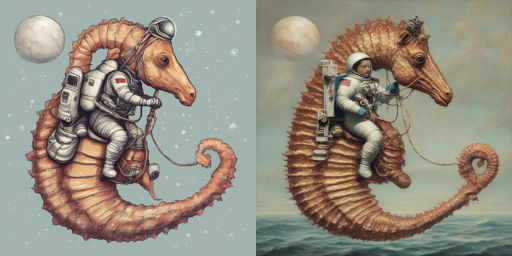

In [67]:
prompt = "An astronaut riding a seahorse"
negative_prompt = "illustration, 2d, cartoon, sketch"

no_negative = pipeline(prompt=prompt, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]
negative = pipeline(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]

utils.make_image_grid([no_negative.resize((256, 256)), negative.resize((256, 256))], rows=1, cols=2)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

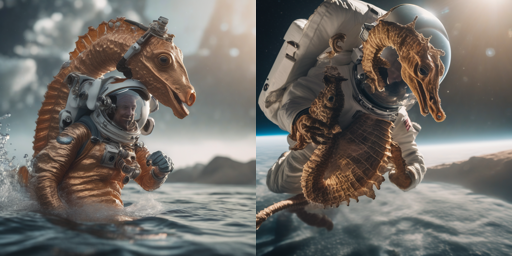

In [68]:
prompt = "An astronaut riding a seahorse, award-wining, high quality, 8k, shot on a Sony A7III"
negative_prompt = "illustration, 2d, cartoon, sketch"

no_negative = pipeline(prompt=prompt, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]
negative = pipeline(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=torch.manual_seed(666)).images[0]

utils.make_image_grid([no_negative.resize((256, 256)), negative.resize((256, 256))], rows=1, cols=2)

## Appendix

In [69]:
# version of Python of the current Jupyter kernel
import sys, datetime

print(f"Current notebook Python version: {sys.version}")
print(f"Notebook last executed: {datetime.datetime.now()}")

Current notebook Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Notebook last executed: 2024-12-15 23:30:12.457233


In [70]:
# package versions when this notebook was last run in Colab (and committed)
!pip freeze

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.9.0.36.21
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.27.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1